In [1]:
# Importing packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import *

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
## Global Var Class ##
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        


## 1. Camera Calibration

In [8]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
show_corners = False

if show_corners:
    fig = plt.figure(figsize=(30, 30))
    rows = 5
    cols = 4

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        if show_corners:
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            ax = plt.subplot(rows, cols, idx + 1)
            ax.set_title(fname)
            plt.imshow(img)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[1::-1], None, None)

## 2. Undisorting sample raw image

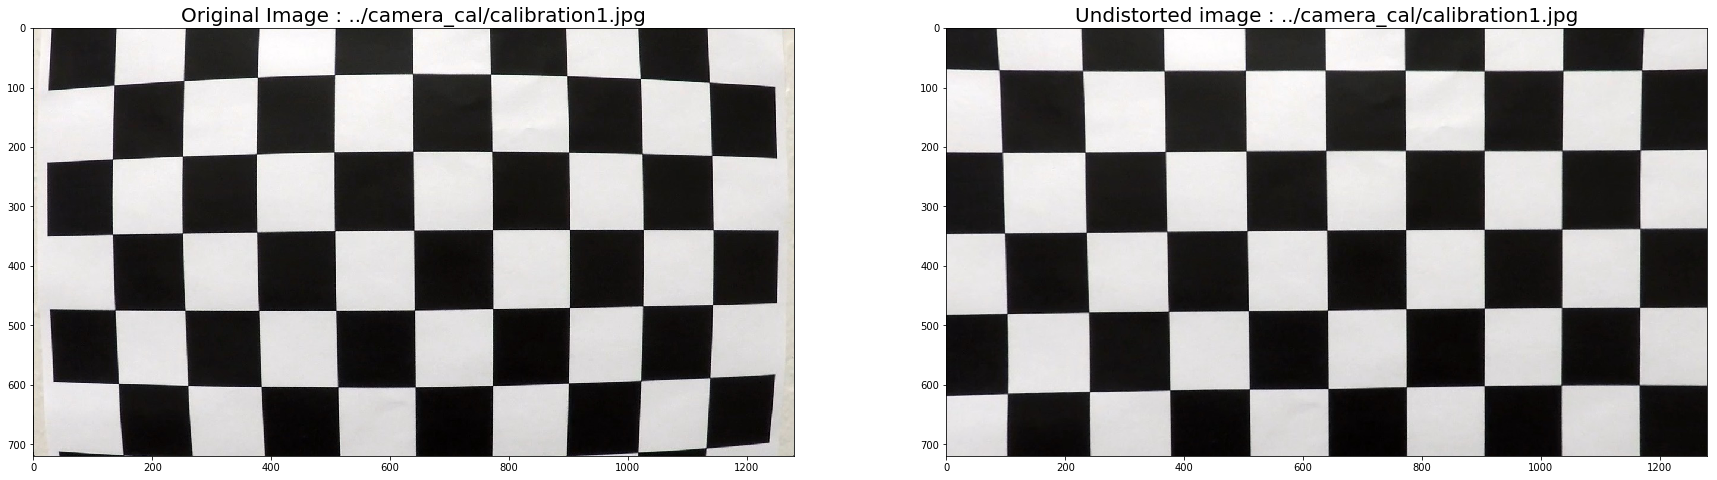

In [17]:
def undist(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def imread_undist(img_path):
    orig_img = mpimg.imread(img_path)
    undist_img = cv2.undistort(orig_img, mtx, dist, None, mtx)
    return undist_img, orig_img


sample_name = "../camera_cal/calibration1.jpg"
dst, sample_img = imread_undist(sample_name)

## plt functions ##
fig = plt.figure(figsize=(30, 30))
rows, cols = 1, 2
ax = plt.subplot(rows, cols, 1)
ax.set_title("Original Image : {}".format(sample_name), fontsize=20)
plt.imshow(sample_img)
ax = plt.subplot(rows, cols, 2)
ax.set_title("Undistorted image : {}".format(sample_name), fontsize=20)
plt.imshow(dst)

## 3. Thresholded binary image

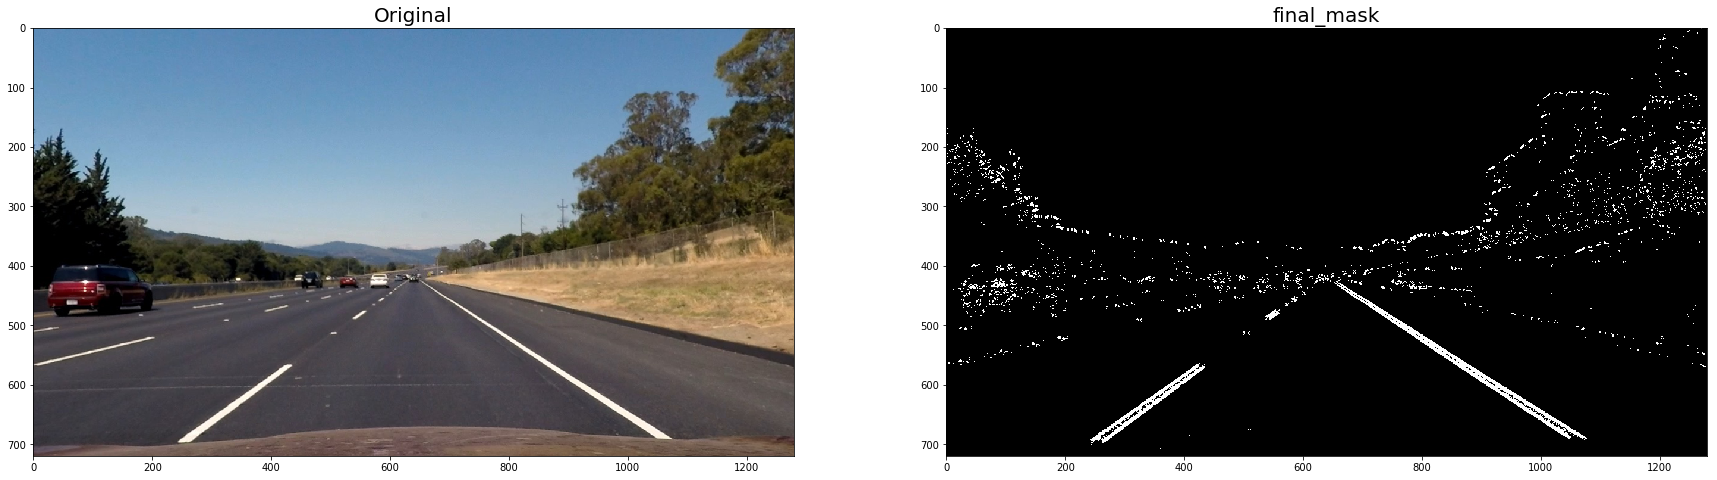

In [18]:
def mag_thres(gray, min_thres, max_thres, ksize):
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    mag = np.sqrt(sobelX**2 + sobelY**2)
    scaled = np.uint8(255*mag/np.max(mag))
    mask = thres(scaled, min_thres, max_thres)
    return mask
    
def dir_thres(gray, min_thres, max_thres, ksize):
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    sobelX = np.abs(sobelX)
    sobelY = np.abs(sobelY)
    direction = np.arctan2(sobelY, sobelX)
    mask = thres(direction, min_thres, max_thres)
    return mask
    
def gen_mask(img, show=2):
    ### Parameters ###
    s_min = 150
    s_max = 250
    
    mag_min = 50
    mag_max = 255
    mag_kernel = 9
    
    dir_min = 0.7
    dir_max = 1.3
    dir_kernel = 9
    ##################
    rgb = np.copy(img)
    
    # Threshold on S channel color values
    hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
    S_mask = thres(hls[:,:,2], s_min, s_max)
    
    # Thereshold on gradient 
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    mag_mask = mag_thres(gray, mag_min, mag_max, mag_kernel)
    
    # Threshold on direction
    dir_mask = dir_thres(gray, dir_min, dir_max, dir_kernel)
    
    # Combining all thresholds
    combined_mask = np.zeros_like(gray)
    combined_mask[((S_mask == 1) | (mag_mask == 1)) & (dir_mask == 1) ] = 1
    
    ## plt functions ##
    if show == 1:
        viz_masks(rgb, S_mask, mag_mask, dir_mask, combined_mask)
    elif show == 2:
        viz_result(rgb, combined_mask)
        mpimg.imsave("../output_images/binary.jpg", combined_mask, cmap='gray')
    return combined_mask

images = glob.glob('../test_images/straigh*')[:1]

for fname in images:
    img, _ = imread_undist(fname)
    gen_mask(img)

## 4. Birds-eye view of lanes

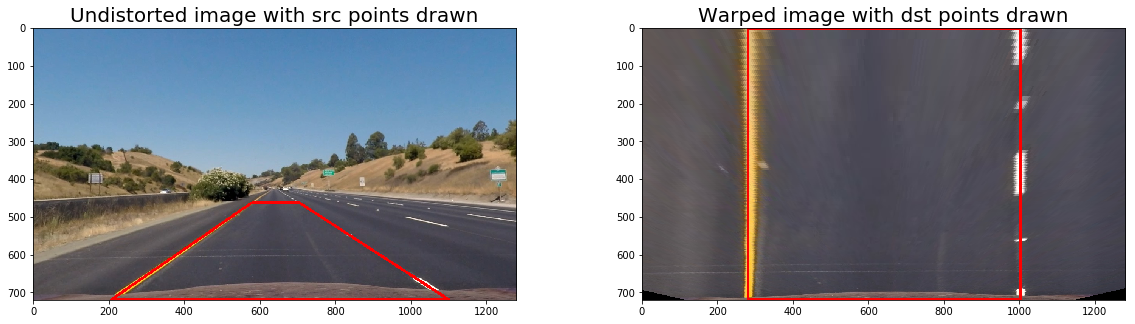

In [90]:
straight_line_img = '../test_images/straight_lines1.jpg'
img, _ = imread_undist(straight_line_img)

src = np.float32([[206, 719], [1100, 719], [704, 462], [578, 462]])
dst = np.float32([[280, 719], [1000, 719], [1000, 0], [280, 0]])
Minv = cv2.getPerspectiveTransform(dst, src)
M = cv2.getPerspectiveTransform(src, dst)

warp_img = warper(img, src, dst)
annotate_src = cv2.polylines(np.copy(img), [np.int32(src)], True, (255, 0, 0), 5)
annotate_dst = cv2.polylines(np.copy(warp_img), [np.int32(dst)], True, (255, 0, 0), 5)

mpimg.imsave("../output_images/warp_straight_lines1.jpg", warp_img)

## plt functions ##
fig = plt.figure(figsize=(20, 5))
utils_plot(annotate_src, 1, 2, 1, "Undistorted image with src points drawn")
utils_plot(annotate_dst, 1, 2, 2, "Warped image with dst points drawn")
plt.savefig("../output_images/warped_straing_lines.jpg")

## 5. Computing Lane bounday

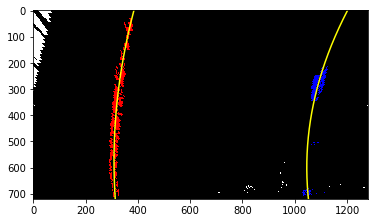

In [33]:
def find_lane_pixels(binary_warped, show_window=0):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if show_window:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, show=1):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[out_img[:,:,0] > 0] = [255, 255, 255]
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if show:
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
    return out_img, left_fit, right_fit, ploty


sample_img = '../test_images/test1.jpg'
img, _ = imread_undist(sample_img)
bin_mask = gen_mask(img, show=0)
plt.figure()
warp_img = warper(bin_mask, src, dst)
out_img, _, _, _ = fit_polynomial(warp_img)


## 5. Measrue Curvature

In [54]:

def measure_curvature_pixels(binary_warped):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Real distance conversion
    my = 3.05/120 # meters per pixel in y dimension
    mx = 3.7/700 # meters per pixel in x dimension

    _, left_fit, right_fit, ploty = fit_polynomial(binary_warped, show=0)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_curve_pix = ((1 + (2 * left_fit[0] * y_eval + left_fit[1])**2)**1.5)/(2 * np.abs(left_fit[0]))  
    right_curve_pix = ((1 + (2 * right_fit[0] * y_eval + right_fit[1])**2)**1.5)/(2 * np.abs(right_fit[0])) 
    
    # Find curvature in real distance
    left_fit_real = [(mx / (my ** 2)) * left_fit[0], (mx/my) * left_fit[1], left_fit[2]]
    right_fit_real = [(mx / (my ** 2)) * right_fit[0], (mx/my) * right_fit[1], right_fit[2]]
    
    y_eval = y_eval * my
    
    left_curve_real = ((1 + (2 * left_fit_real[0] * y_eval + left_fit_real[1])**2)**1.5)/(2 * np.abs(left_fit_real[0])) 
    right_curve_real = ((1 + (2 * right_fit_real[0] * y_eval + right_fit_real[1])**2)**1.5)/(2 * np.abs(right_fit_real[0]))
     
    return left_curve_pix, right_curve_pix, left_curve_real, right_curve_real


sample_img = '../test_images/test2.jpg'
img, _ = imread_undist(sample_img)
bin_mask = gen_mask(img, show=0)
warp_img = warper(bin_mask, src, dst)
l_pix, r_pix, l_real, r_real = measure_curvature_pixels(warp_img)
print("Left lane curvature : {:.2f} pix, right lane curvature : {:.2f} pix".format(l_pix, r_pix))
print("Left lane curvature : {:.2f} m, right lane curvature : {:.2f} m".format(l_real, r_real))

Left lane curvature : 3133.16 pix, right lane curvature : 3895.23 pix
Left lane curvature : 382.46 m, right lane curvature : 473.19 m


## 6. Lane bounday on image

In [85]:
def weighted_img(img, initial_img, α=0.8, β=0.5, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def get_car_offset(left_warped_x, right_warped_x, y, w, mx=3.7/700):
    left_unwarped_X  = cv2.perspectiveTransform(np.float32([[[left_warped_x, y]]]), Minv)
    right_unwarped_X = cv2.perspectiveTransform(np.float32([[[right_warped_x, y]]]), Minv)
    lane_center = (right_unwarped_X + left_unwarped_X) / 2
    lane_center = lane_center[0][0][0]
    offset = lane_center - (w / 2)
    offset_real = offset * mx
    return offset_real
    
    
def color_lane(img):
    bin_mask = gen_mask(img, show=0)
    warp_img = warper(bin_mask, src, dst)
    _, left_fit, right_fit, ploty = fit_polynomial(warp_img, show=0)
    
    h, w, _ = out_img.shape
    idx = np.float32(np.mgrid[0:w,0:h].T.reshape(-1,2))
    
    left_mask = (idx[:,0]  - (left_fit[0]*idx[:,1]**2 + left_fit[1]*idx[:,1] + left_fit[2])) > 0
    left_mask = left_mask.reshape(h, w)
    right_mask = (idx[:,0]  - (right_fit[0]*idx[:,1]**2 + right_fit[1]*idx[:,1] + right_fit[2])) < 0
    right_mask = right_mask.reshape(h, w)
    road_mask = left_mask & right_mask
    

    road_color_img = np.zeros_like(img)
    road_color_img[road_mask] = [0, 255, 0]
    
    orig_view = warper(road_color_img, dst, src)
    colored_img = weighted_img(orig_view, img)
    return colored_img

def color_lane2(image):
    
    bin_mask = gen_mask(image, show=0)
    warped = warper(bin_mask, src, dst)
    
    _, left_fit, right_fit, ploty = fit_polynomial(warped, show=0)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    
    # Get car offset
    offset_real = get_car_offset(left_fitx[-1], right_fitx[-1], ploty[-1], warped.shape[1])
    
    text = "Vehicle is {:.2f}m {} of center".format(abs(offset_real), "left" if offset_real > 0 else "right")
    result = cv2.putText(result, text, (50, 50) , cv2.FONT_HERSHEY_SIMPLEX , 1, (255, 255, 255) , 2, cv2.LINE_AA) 
    
#     plt.imshow(result)
    
    return result, offset_real
    
sample_img = '../test_images/straight_lines2.jpg'
img, _ = imread_undist(sample_img)
output, offset = color_lane2(img)
print("Offset : {}".format(offset))

Offset : 0.10990117536272322


## 7. Processing on a video

In [88]:
def pipeline(image):
    img = undist(image, mtx, dist)
    out,_ = color_lane2(img)
    return out
    
lane_fit_output = '../output_images/output.mp4'
clip1 = VideoFileClip("../project_video.mp4").subclip(0,5)
lane_clip = clip1.fl_image(pipeline) 
%time lane_clip.write_videofile(lane_fit_output, audio=False)

[MoviePy] >>>> Building video ../output_images/output.mp4
[MoviePy] Writing video ../output_images/output.mp4


 99%|█████████▉| 125/126 [00:31<00:00,  3.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/output.mp4 

CPU times: user 21.1 s, sys: 1.48 s, total: 22.6 s
Wall time: 34.2 s


In [89]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lane_fit_output))